In [1]:
import numpy as np
import ogb
from ogb.graphproppred import PygGraphPropPredDataset
from torch_geometric.data import DataLoader
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from utils import get_nx_graph, color_mapper, draw_legend

In [101]:
d_name = 'ogbg-ppa'
dataset = PygGraphPropPredDataset(name=d_name) 

split_idx = dataset.get_idx_split() 
bs = 1
train_loader = DataLoader(dataset[split_idx["train"]], batch_size=bs, shuffle=True)

In [104]:
def draw_ppa_ego(ego, edge_feature_idx=0):
    edge_list = ego.edge_index.numpy().T
    edge_feats = {(edge[0], edge[1]): ego.edge_attr[e] for e, edge in enumerate(edge_list)}
    edge_labels = {edge: edge_feats[edge][edge_feature_idx].item() for edge in edge_feats}
    G = get_nx_graph(ego)
    pos = nx.spring_layout(G)
    ecs = [np.asarray([1.0, 1.0, 1.0]) - edge_labels[edge] for edge in G.edges]
    plt.figure(figsize=(2,2), dpi=250)
    plt.box(False)
    nx.draw_networkx(G, pos=pos, with_labels=False, node_size=2.5, node_color='indianred', edge_color=ecs, width=0.8)
    plt.show()
    plt.close()
    return    

def filter_out_edges(ego, thresholds, filt=np.all):
    edge_list = ego.edge_index.numpy().T
    edge_feats = ego.edge_attr.numpy()
    assert len(thresholds)==edge_feats.shape[1]
    mask = np.repeat(a=np.asarray(thresholds).reshape((1, edge_feats.shape[1])), repeats=edge_list.shape[0], axis=0)
    comp = edge_feats > mask
    to_keep = filt(comp, axis=1)
#     print(edge_feats[:10], '\n', mask[:10], '\n', comp[:10], '\n', to_keep)
    return edge_list[to_keep]

In [176]:
amount = 10

count = 0
for ego in train_loader:
    edge_list = filter_out_edges(ego, 0.9*np.asarray([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]), np.any)
    print(ego.edge_index.shape[1])
    print(edge_list.shape[0])
    print(100*edge_list.shape[0]/ego.edge_index.shape[1])
    print('-----')
    count += 1
    if count >= amount:
        break

5244
500
9.534706331045005
-----
724
0
0.0
-----
3284
70
2.131546894031669
-----
5584
550
9.849570200573066
-----
5062
2698
53.29909126827341
-----
1904
34
1.7857142857142858
-----
7846
18
0.22941626306398163
-----
4940
340
6.882591093117409
-----
5166
556
10.762679055361982
-----
11380
2832
24.885764499121265
-----


In [174]:
amount = +np.inf

count = 0
edge_feats = list()
for ego in train_loader:
    count += 1
    edge_feats.append(ego.edge_attr.numpy())
    if count >= amount:
        break
edge_feats = np.vstack(edge_feats)
print(np.median(edge_feats, axis=0))

KeyboardInterrupt: 

In [163]:
print(np.percentile(edge_feats, 95, axis=0))

[0.61900002 0.         0.68800002 0.847      0.93400002 0.80000001
 0.60900003]


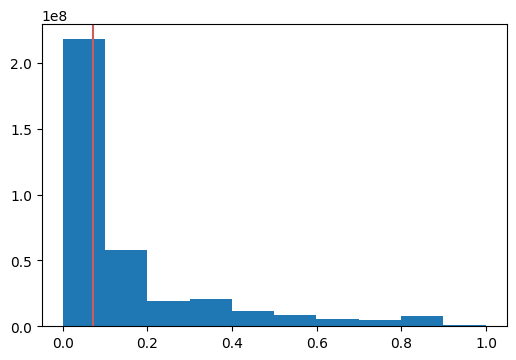

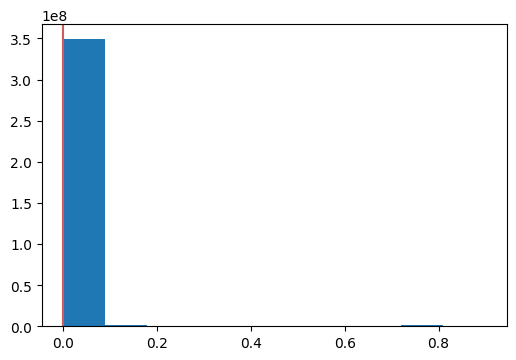

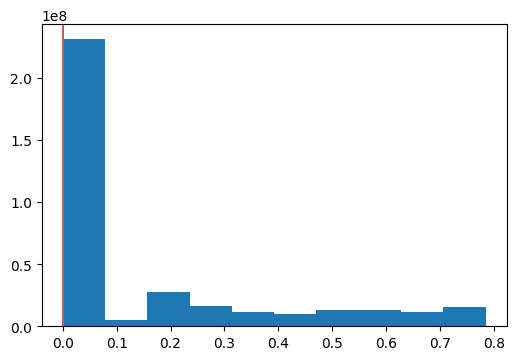

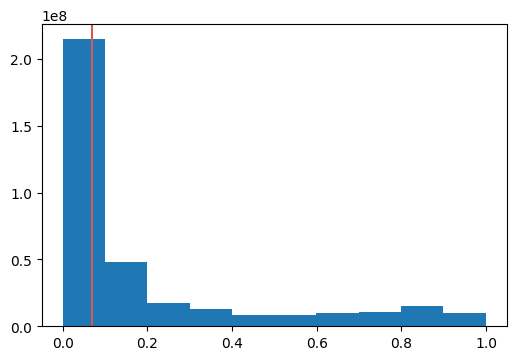

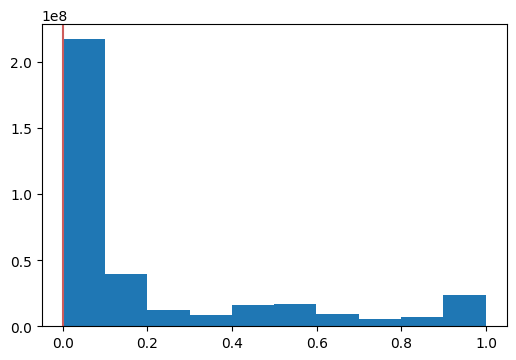

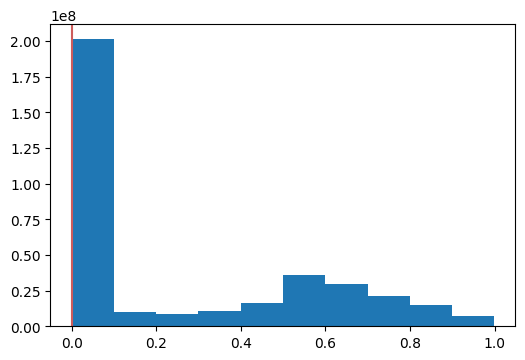

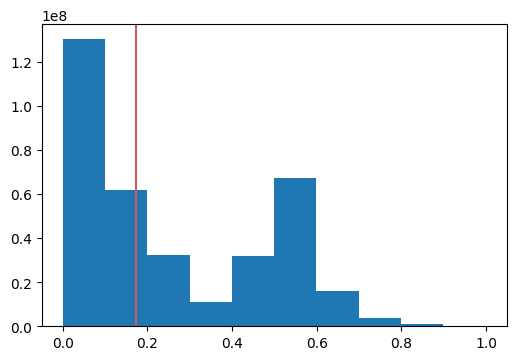

In [164]:
for f in range(7):
    plt.figure(dpi=100)
    plt.hist(edge_feats[:,f], log=False)
    plt.axvline(x=np.median(edge_feats[:,f]), color='indianred')
    plt.show()
    plt.close()

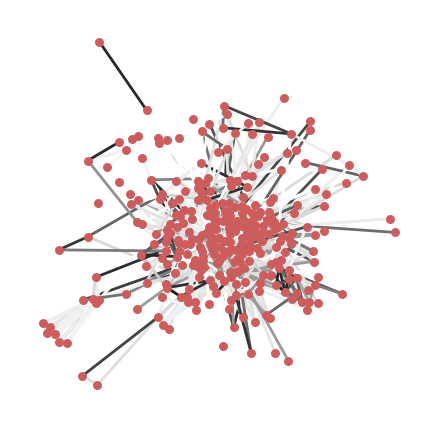

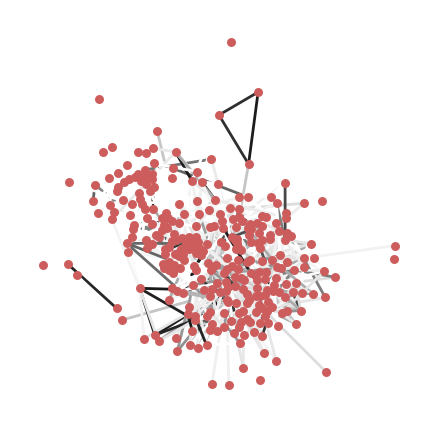

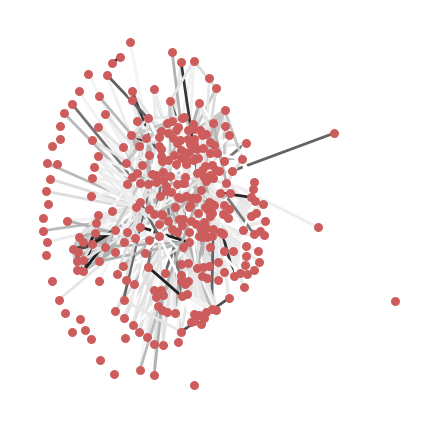

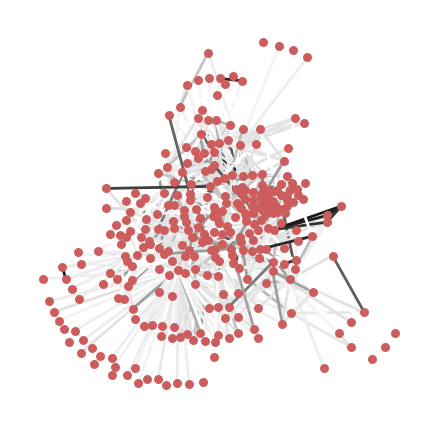

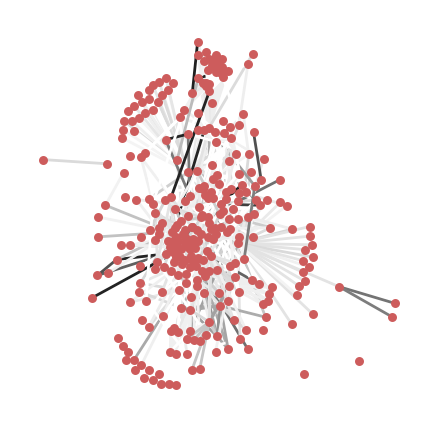

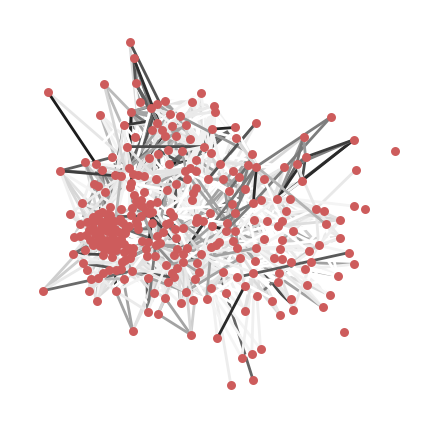

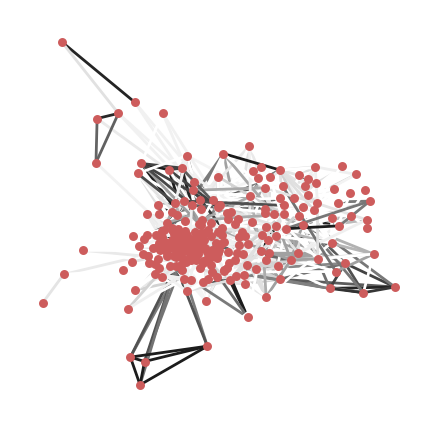

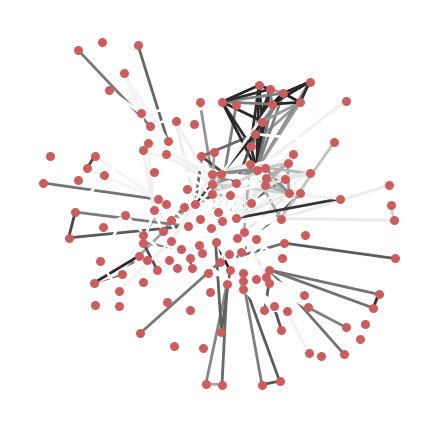

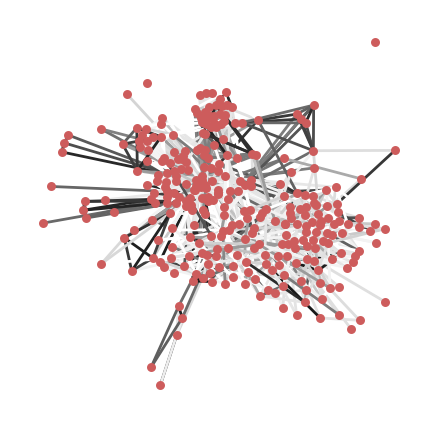

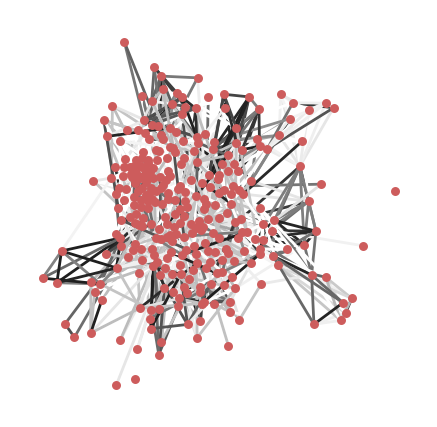

In [100]:
amount = 10

count = 0
for ego in train_loader:
    count += 1
    draw_ppa_ego(ego)
    if count >= amount:
        break

In [191]:
%%time

max_clique_size = 6
sample_size = 100
thresholds = 0.9 * np.asarray([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
filt = np.any

H = np.zeros((sample_size, max_clique_size+1))
count = 0
for e, ego in enumerate(train_loader):
    edges = filter_out_edges(ego, thresholds, filt)
    G = nx.from_edgelist(edges)
    for clique in nx.algorithms.clique.enumerate_all_cliques(G):
        size = len(clique)
        if size > max_clique_size:
            break
        H[e, size] += 1
    count += 1
    print('\r{}/{}    ...'.format(count, sample_size), end='')
    if count >= sample_size:
        break
print('Dataset: {}'.format(d_name))
print('Number of overall (maximal) triangles: {}'.format(H[:,3].sum()))
print('Number of egos with at least one (maximal) triangle: {} (median: {:.2f} per ego)'.format((H[:,3]>0).sum(), np.median(H[:,3])))
print('Number of egos with at least one (maximal) 4-clique: {} (median: {:.2f} per ego)'.format((H[:,4]>0).sum(), np.median(H[:,4])))
print('Number of egos with at least one (maximal) 5-clique: {} (median: {:.2f} per ego)'.format((H[:,5]>0).sum(), np.median(H[:,5])))
print('Number of egos with at least one (maximal) 6-clique: {} (median: {:.2f} per ego)'.format((H[:,6]>0).sum(), np.median(H[:,6])))
print('Number of overall egos: {}'.format(H.shape[0]))
print('-------------------------------------------------'

100/100    ...Dataset: ogbg-ppa
Number of overall (maximal) triangles: 207088.0
Number of egos with at least one (maximal) triangle: 83 (median: 47.50 per ego)
Number of egos with at least one (maximal) 4-clique: 68 (median: 29.00 per ego)
Number of egos with at least one (maximal) 5-clique: 56 (median: 11.00 per ego)
Number of egos with at least one (maximal) 6-clique: 51 (median: 1.00 per ego)
Number of overall egos: 100
-------------------------------------------------
CPU times: user 1h 3min 17s, sys: 2min 42s, total: 1h 6min
Wall time: 1h 5min 48s


In [192]:
%%time

max_clique_size = 6
sample_size = 100
thresholds = 0.95 * np.asarray([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
filt = np.any

H = np.zeros((sample_size, max_clique_size+1))
count = 0
for e, ego in enumerate(train_loader):
    edges = filter_out_edges(ego, thresholds, filt)
    G = nx.from_edgelist(edges)
    for clique in nx.algorithms.clique.enumerate_all_cliques(G):
        size = len(clique)
        if size > max_clique_size:
            break
        H[e, size] += 1
    count += 1
    print('\r{}/{}    ...'.format(count, sample_size), end='')
    if count >= sample_size:
        break
print('Dataset: {}'.format(d_name))
print('Number of overall (maximal) triangles: {}'.format(H[:,3].sum()))
print('Number of egos with at least one (maximal) triangle: {} (median: {:.2f} per ego)'.format((H[:,3]>0).sum(), np.median(H[:,3])))
print('Number of egos with at least one (maximal) 4-clique: {} (median: {:.2f} per ego)'.format((H[:,4]>0).sum(), np.median(H[:,4])))
print('Number of egos with at least one (maximal) 5-clique: {} (median: {:.2f} per ego)'.format((H[:,5]>0).sum(), np.median(H[:,5])))
print('Number of egos with at least one (maximal) 6-clique: {} (median: {:.2f} per ego)'.format((H[:,6]>0).sum(), np.median(H[:,6])))
print('Number of overall egos: {}'.format(H.shape[0]))
print('-------------------------------------------------')

100/100    ...Dataset: ogbg-ppa
Number of overall (maximal) triangles: 79266.0
Number of egos with at least one (maximal) triangle: 73 (median: 6.50 per ego)
Number of egos with at least one (maximal) 4-clique: 55 (median: 1.00 per ego)
Number of egos with at least one (maximal) 5-clique: 41 (median: 0.00 per ego)
Number of egos with at least one (maximal) 6-clique: 38 (median: 0.00 per ego)
Number of overall egos: 100
-------------------------------------------------
CPU times: user 12min 46s, sys: 28.9 s, total: 13min 15s
Wall time: 13min 9s


In [193]:
%%time

max_clique_size = 6
sample_size = 100
thresholds = 0.92 * np.asarray([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
filt = np.any

H = np.zeros((sample_size, max_clique_size+1))
count = 0
for e, ego in enumerate(train_loader):
    edges = filter_out_edges(ego, thresholds, filt)
    G = nx.from_edgelist(edges)
    for clique in nx.algorithms.clique.enumerate_all_cliques(G):
        size = len(clique)
        if size > max_clique_size:
            break
        H[e, size] += 1
    count += 1
    print('\r{}/{}    ...'.format(count, sample_size), end='')
    if count >= sample_size:
        break
print('Dataset: {}'.format(d_name))
print('Number of overall (maximal) triangles: {}'.format(H[:,3].sum()))
print('Number of egos with at least one (maximal) triangle: {} (median: {:.2f} per ego)'.format((H[:,3]>0).sum(), np.median(H[:,3])))
print('Number of egos with at least one (maximal) 4-clique: {} (median: {:.2f} per ego)'.format((H[:,4]>0).sum(), np.median(H[:,4])))
print('Number of egos with at least one (maximal) 5-clique: {} (median: {:.2f} per ego)'.format((H[:,5]>0).sum(), np.median(H[:,5])))
print('Number of egos with at least one (maximal) 6-clique: {} (median: {:.2f} per ego)'.format((H[:,6]>0).sum(), np.median(H[:,6])))
print('Number of overall egos: {}'.format(H.shape[0]))
print('-------------------------------------------------')

100/100    ...Dataset: ogbg-ppa
Number of overall (maximal) triangles: 139955.0
Number of egos with at least one (maximal) triangle: 83 (median: 21.00 per ego)
Number of egos with at least one (maximal) 4-clique: 69 (median: 13.50 per ego)
Number of egos with at least one (maximal) 5-clique: 59 (median: 4.00 per ego)
Number of egos with at least one (maximal) 6-clique: 50 (median: 0.50 per ego)
Number of overall egos: 100
-------------------------------------------------
CPU times: user 36min 59s, sys: 1min 33s, total: 38min 33s
Wall time: 38min 24s
